In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard.notebook

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# set up tensorboard log directory
logdir="tf_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(logdir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# need the following to successfully run. 
# Otherwise there will be cuDNN error in training 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
sess.as_default()

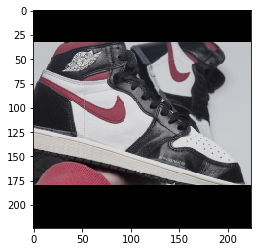

In [3]:
import skimage
import random

# define dataloader and preprocessing
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

# the following does not work with eager execution
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = image/255  # normalize to [0,1] range
    image = tf.image.resize_with_pad(image, 256, 256)
    image = tf.image.random_crop(image, (224, 224, 3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.clip_by_value(image, 0, 1)
    # tensorflow2.0 does not have tf.conrib.image.rotate()
#     image = tf.convert_to_tensor(skimage.transform.rotate(image.numpy(), rot_angle))
    return image

# # define dataloader and preprocessing
# def load_and_preprocess_image(path):
#     image = tf.io.read_file(path)
#     return preprocess_image(image)

# # the following does not work with eager execution
# def preprocess_image(image):
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = image/255  # normalize to [0,1] range
#     # randomly rotate image for data augmentation
#     rotate_range=30
#     rot_angle = random.randint(-rotate_range, rotate_range)
#     image = tf.convert_to_tensor(skimage.transform.rotate(image.numpy(), rot_angle))
#     image = tf.image.resize_with_pad(image, 256, 256)
#     image = tf.image.random_crop(image, (224, 224, 3))
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, 0.3)
#     image = tf.image.random_contrast(image, 0.7, 1.3)
#     image = tf.image.random_saturation(image, 0.7, 1.3)
#     # tensorflow2.0 does not have tf.conrib.image.rotate()
# #     image = tf.convert_to_tensor(skimage.transform.rotate(image.numpy(), rot_angle))
#     return image

# def load_and_preprocess_image(path):
#     return preprocess_image(path)
# def preprocess_image(image):
#     image = skimage.io.imread(image)
# #     image = tf.image.decode_jpeg(image, channels=3)
#     image = image/255  # normalize to [0,1] range
#     # randomly rotate image for data augmentation
# #     print(image)
#     rotate_range=30
#     rot_angle = random.randint(-rotate_range, rotate_range)
#     image = skimage.transform.rotate(image, rot_angle)
#     image = tf.convert_to_tensor(image)
#     image = tf.image.resize_with_pad(image, 256, 256)
#     image = tf.image.random_crop(image, (224, 224, 3))
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, 0.3)
#     image = tf.image.random_contrast(image, 0.7, 1.3)
#     image = tf.image.random_saturation(image, 0.7, 1.3)
#     # tensorflow2.0 does not have tf.conrib.image.rotate()
# #     image = tf.convert_to_tensor(skimage.transform.rotate(image.numpy(), rot_angle))
#     return image

path = "/home/nan/sneaker_ai/screened_data/air_jordan_1/air_jordan_1_362.png"
plt.imshow(load_and_preprocess_image(path))

/home/nan/sneaker_ai/screened_data/air_jordan_6/air_jordan_6_334.jpg


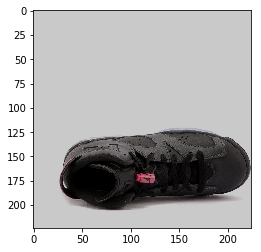

In [4]:
# test random data loaders
train_df = pd.read_csv("train_df.csv")
indx = random.randint(0, len(train_df))
path = train_df.iloc[indx, 1]
print(path)
plt.imshow(load_and_preprocess_image(path))

In [5]:
# set up datasets
from sklearn.utils import shuffle
train_df = shuffle(train_df)
train_image_paths = train_df.loc[:, "Image_File"].tolist()
train_image_labels = train_df.loc[:, "Label"].tolist()

test_df = pd.read_csv("test_df.csv")
# test_df = shuffle(test_df)
test_image_paths = test_df.loc[:, "Image_File"].tolist()
test_image_labels = test_df.loc[:, "Label"].tolist()
# covertion between class names and model outputs
label_names = ["AJ "+str(i) for i in range(1,24)]
label_to_index = dict((name, index) 
                      for index, name in enumerate(label_names))

train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

train_ds = train_ds.map(load_and_preprocess_from_path_label)
test_ds = test_ds.map(load_and_preprocess_from_path_label)

In [6]:
# specify batch size and buffering for datasets
BATCH_SIZE = 64

# # Setting a shuffle buffer size as large as the dataset ensures that the data is
# # completely shuffled.
# train_ds = train_ds.apply(
#   tf.data.experimental.shuffle_and_repeat(buffer_size=len(train_df)))
# do the following to save some ram, otherwise training will stop
train_ds = train_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=256))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# do the following to save some ram, otherwise training will stop
test_ds = test_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=256))
# test_ds = test_ds.apply(
#   tf.data.experimental.shuffle_and_repeat(buffer_size=len(test_df)))
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [7]:
# import mobilenet v2 model
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224,224, 3), include_top=False)
# mobile_net.trainable=False
mobile_net.trainable=True

In [8]:
# MobileNetV2: https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
# imagenet.utils: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
# mobile net expects prepocessed input ranging from -1 to 1
def change_range(image,label=0):
    return 2*image-1, label

train_ds = train_ds.map(change_range)
test_ds = test_ds.map(change_range)

In [9]:
regularizer = 0.2;
# add fc layers after mobilenet for transfer learning
model = tf.keras.Sequential([
    mobile_net,
    # take an average of each channel so that the model woks with different input sizes
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(512, activation = tf.nn.relu),
    tf.keras.layers.Dense(256, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(regularizer)),
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(64, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(regularizer)),
#     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_names), activation=tf.nn.softmax, kernel_regularizer=tf.keras.regularizers.l2(regularizer))])

In [10]:
# configure model optimizer, loss
# model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-6), 
#               loss=tf.keras.losses.sparse_categorical_crossentropy,
#               metrics=["accuracy"])

# learning_rate=5e-6 was tuned for batch size 16
# larger batch allows for greater learning rate
model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-5), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 23)                1

In [12]:
%tensorboard --logdir {logdir}

In [13]:
# model training
num_epochs = 30
training_history = model.fit(train_ds, epochs=num_epochs, 
                             validation_data=test_ds,
                             callbacks=[tensorboard_callback],
                             verbose=2,
                            )

Epoch 1/30
89/89 - 143s - loss: 107.5322 - accuracy: 0.0576 - val_loss: 98.9684 - val_accuracy: 0.0584
Epoch 2/30
89/89 - 94s - loss: 91.1229 - accuracy: 0.0744 - val_loss: 83.8670 - val_accuracy: 0.0584
Epoch 3/30
89/89 - 94s - loss: 77.0887 - accuracy: 0.1104 - val_loss: 70.8737 - val_accuracy: 0.0815
Epoch 4/30
89/89 - 94s - loss: 65.1385 - accuracy: 0.1580 - val_loss: 59.8555 - val_accuracy: 0.1277
Epoch 5/30
89/89 - 95s - loss: 55.0346 - accuracy: 0.2242 - val_loss: 50.5633 - val_accuracy: 0.2045
Epoch 6/30
89/89 - 96s - loss: 46.5221 - accuracy: 0.2877 - val_loss: 42.7944 - val_accuracy: 0.2908
Epoch 7/30
89/89 - 95s - loss: 39.3863 - accuracy: 0.3655 - val_loss: 36.2734 - val_accuracy: 0.3845
Epoch 8/30
89/89 - 97s - loss: 33.4105 - accuracy: 0.4486 - val_loss: 30.8380 - val_accuracy: 0.4518
Epoch 9/30
89/89 - 98s - loss: 28.4488 - accuracy: 0.5098 - val_loss: 26.2823 - val_accuracy: 0.5292
Epoch 10/30
89/89 - 98s - loss: 24.3131 - accuracy: 0.5676 - val_loss: 22.5209 - val_accu

In [14]:
tf.saved_model.save(model, os.path.join(logdir, "model"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 23)                1

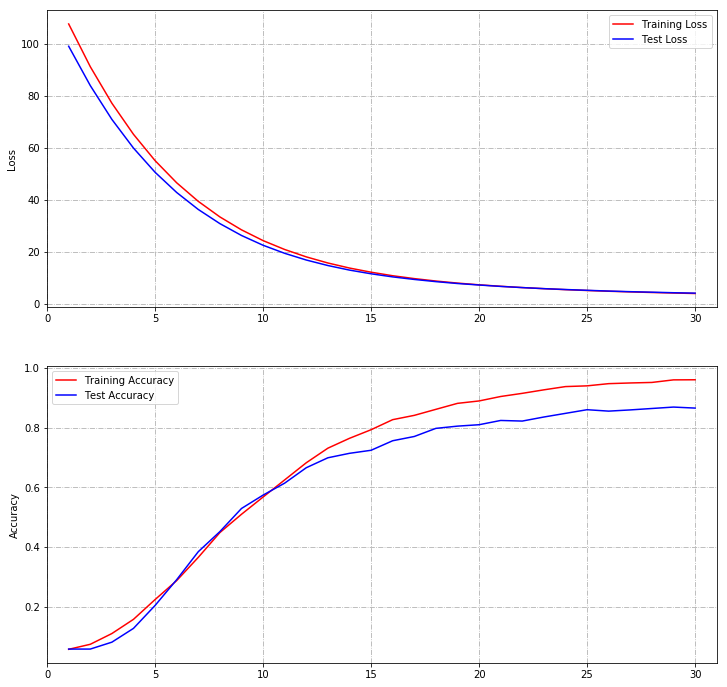

In [15]:
# plot training and validation history
hist = training_history.history
train_loss = hist["loss"]
test_loss = hist["val_loss"]
train_accuracy = hist["accuracy"]
test_accuracy = hist["val_accuracy"]

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, len(train_loss) + 1])
plt.ylabel('Loss')
plt.plot(range(1, len(train_loss)+1), train_loss, 'r', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Test Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, len(train_accuracy) + 1])
plt.ylabel('Accuracy')
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'r', label='Training Accuracy')
plt.plot(range(1, len(test_accuracy)+1), test_accuracy, 'b', label='Test Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.savefig(os.path.join(logdir, 'training_hist.png'))

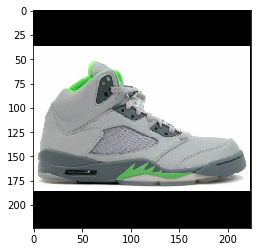

In [18]:
# def img_preprocessing(path):
#     img = load_and_preprocess_image(path)
#     img, _ = change_range(img,label=0)
#     return img

def img_preprocessing(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = image/255  # normalize to [0,1] range
    image = tf.image.resize_with_pad(image,224,224)
    image, _ = change_range(image,label=0)
    return image

test_df = pd.read_csv("test_df.csv")
test_image_paths = test_df.loc[:, "Image_File"].tolist()
test_image_labels = test_df.loc[:, "Label"].tolist()

rand_indx = random.randint(0, len(test_image_paths)-1)
img = img_preprocessing(test_image_paths[rand_indx]) 
plt.imshow((img+1)/2)

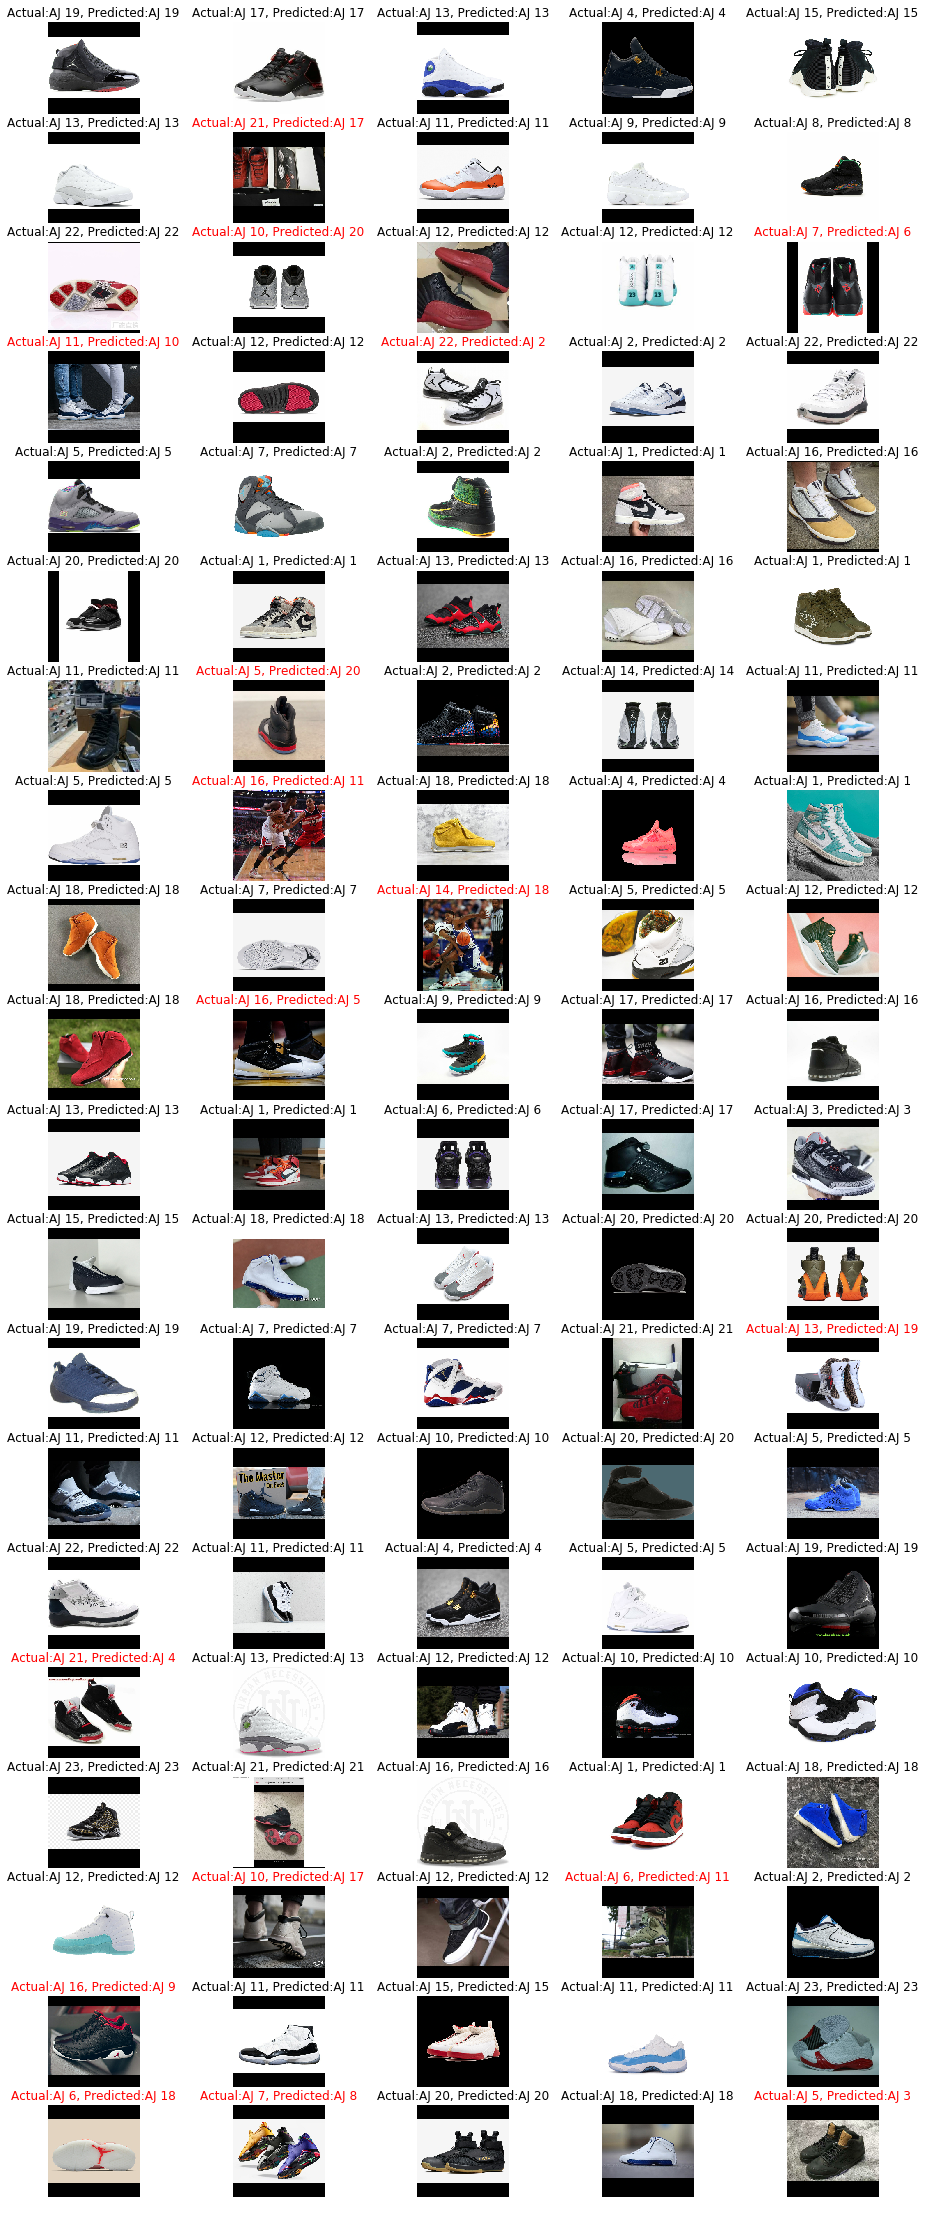

In [17]:
num_images=100
classes = ["AJ "+str(i) for i in range(1,24)]
indices = np.random.choice(len(test_image_paths), num_images, replace=False)
inputs = np.empty(shape=(num_images,224,224,3))
targets = np.empty(shape=(num_images))
for i, indx in enumerate(indices):
    inputs[i,:,:,:] = img_preprocessing(test_image_paths[indx]).numpy()
    targets[i] = test_image_labels[indx]
output = model.predict(inputs)
prediction = output.argmax(axis=1)
targets = targets.astype(int)
# output.shape
# output.argmax(axis=1)==targets

images_so_far = 0
fig = plt.figure(figsize=(16,40))

for i in range(num_images):
    images_so_far += 1
    ax = plt.subplot(num_images//5, 5, images_so_far)
    ax.axis('off')
    ax.set_title('Actual:{}, Predicted:{}'.format(classes[targets[i]], classes[prediction[i]]),
    color = 'k' if targets[i]==prediction[i] else 'r' )
    plt.imshow((inputs[i,:,:,:]+1)/2)  # need to transform range from [-1,1] to [0,1]

plt.savefig(os.path.join(logdir, 'example_output.png'))